In [8]:
# Imports
from pathlib import Path
from typing import Tuple, List
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gcsfs
from numba import njit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import matplotlib.pyplot as plt
# Globals, this one is downloading from the google cloud 
FILE_SYSTEM = gcsfs.core.GCSFileSystem(requester_pays=True)
# CAMELS_ROOT = Path('pangeo-ncar-camels/basin_dataset_public_v1p2')
CAMELS_ROOT = Path('camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available

In [2]:
DEVICE

device(type='cpu')

In [3]:
CAMELS_ROOT

PosixPath('camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2')

**We try the code for BEAR RIVER in IDAHO UTAH STATE, we use the code ID 10092700**

In [4]:
#basin = '01013500'
basin='10092700'#bear river at IDAHO UTAH STATE LINE
# This is the Root directory of meteorological forcings
# forcing_path = 'camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/daymet'
forcing_path = CAMELS_ROOT / 'basin_mean_forcing' / 'daymet'

#now using the glob to get to the pathof the files
#searching for a file that has this basin ID and is ending with 'txt' it does it continously/recursively
files = list(glob.glob(os.path.join(forcing_path, '**', f'{basin}_*.txt'), recursive=True))

#then we print the list of files that are found
print(files)

#  if no files were found it will raise an error if so
if len(files) == 0:
    raise RuntimeError(f'No forcing file found for Basin {basin}')
else:
    # what if we assume we want to use the first file found
    file_path = files[0]
    print("Using file:", file_path)
    
with open(file_path, 'r') as fp:
    df = pd.read_csv(fp, sep='\s+', header=3)
dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
         + df.Day.map(str))
df.index = pd.to_datetime(dates, format="%Y/%m/%d")

with open(file_path, 'r') as fp:
    content = fp.readlines()
    area = int(content[2])
    
df

[]


RuntimeError: No forcing file found for Basin 10092700

**Because the basin Id we have given the code is not in the CAMELS dataset, we get the above error. The next thing we should do is actually searching for the basin IDs present in the CAMELS dataset and trying with them instead, so this [htmlfor CAMEL BASIN IDS](https://gdex.ucar.edu/dataset/camels/file/basin_timeseries_v1p2_metForcing_obsFlow.zip/content.html) contains different basin IDs used listed as basin_dataset_public_v1p2/elev_bands_forcing/daymet/07/05585000... this number at the end 05585000 is the basin ID so there are different ones listed, but we can not tell what region ius being represented so we go on this [USGS SEARCH](https://wdr.water.usgs.gov/allsearch.php) to search the region that the basin ID represents.**

**We try with another ID that is actually present in the CAMELS dataset and search for its region**

**02053800, this number when searched on [USGS SEARCH](https://wdr.water.usgs.gov/allsearch.php)  is showing that the region is VIRGINIA** 

In [120]:
basin='02053800'#VIRGINIA
#for idaho present in the dataset
#>>basin='12411000' #works
#>>basin='12414500'#works
#>basin='13083000'#wo
#>basin='13235000'#wo
#>basin='13240000'#wo
#>basin='13310700'#wo
#>basin='13313000'
#>basin='13337000'
#>basin='13338500'
#>basin='13340000'#wo
#>basin='13340600'#wo
#Other regions of the Pacific Northwest were tried and GreatBasin were tried using the region number
# This is the Root directory of meteorological forcings
# forcing_path = 'camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/daymet'
forcing_path = CAMELS_ROOT / 'basin_mean_forcing' / 'daymet'

#now using the glob to get to the pathof the files
#searching for a file that has this basin ID and is ending with 'txt' it does it continously/recursively
files = list(glob.glob(os.path.join(forcing_path, '**', f'{basin}_*.txt'), recursive=True))

#then we print the list of files that are found
print(files)

#  if no files were found it will raise an error if so
if len(files) == 0:
    raise RuntimeError(f'No forcing file found for Basin {basin}')
else:
    # what if we assume we want to use the first file found
    file_path = files[0]
    print("Using file:", file_path)
    
with open(file_path, 'r') as fp:
    df = pd.read_csv(fp, sep='\s+', header=3)
dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
         + df.Day.map(str))
df.index = pd.to_datetime(dates, format="%Y/%m/%d")

with open(file_path, 'r') as fp:
    content = fp.readlines()
    area = int(content[2])
    
df

['camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/daymet/03/02053800_lump_cida_forcing_leap.txt']
Using file: camels-20240502T2331Z/basin_timeseries_v1p2_metForcing_obsFlow/basin_dataset_public_v1p2/basin_mean_forcing/daymet/03/02053800_lump_cida_forcing_leap.txt


,Year,Mnth,Day,Hr,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
1980-01-01,1980,1,1,12,34214.39,0.00,250.26,0.0,6.81,-3.50,468.24
1980-01-02,1980,1,2,12,34214.39,0.00,247.38,0.0,5.38,-4.54,435.95
1980-01-03,1980,1,3,12,34214.39,0.00,237.29,0.0,6.02,-3.19,483.55
1980-01-04,1980,1,4,12,34214.39,0.00,190.49,0.0,3.08,-3.60,468.13
1980-01-05,1980,1,5,12,34263.54,10.21,84.61,0.0,-1.42,-4.94,425.26
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,2014,12,27,12,34210.43,0.00,284.99,0.0,12.64,-3.10,488.99
2014-12-28,2014,12,28,12,34214.39,0.00,278.29,0.0,16.76,1.44,673.01
2014-12-29,2014,12,29,12,34214.39,6.31,100.35,0.0,10.70,5.87,920.17
2014-12-30,2014,12,30,12,34214.39,7.16,162.75,0.0,6.59,-1.66,542.24


Column interpretations: Snow Water Equivalent (swe(mm)), Vapor Pressure (vp(Pa)), Daylight (dayl(s)), 

Correlation matrix will help us see the relations between variables 

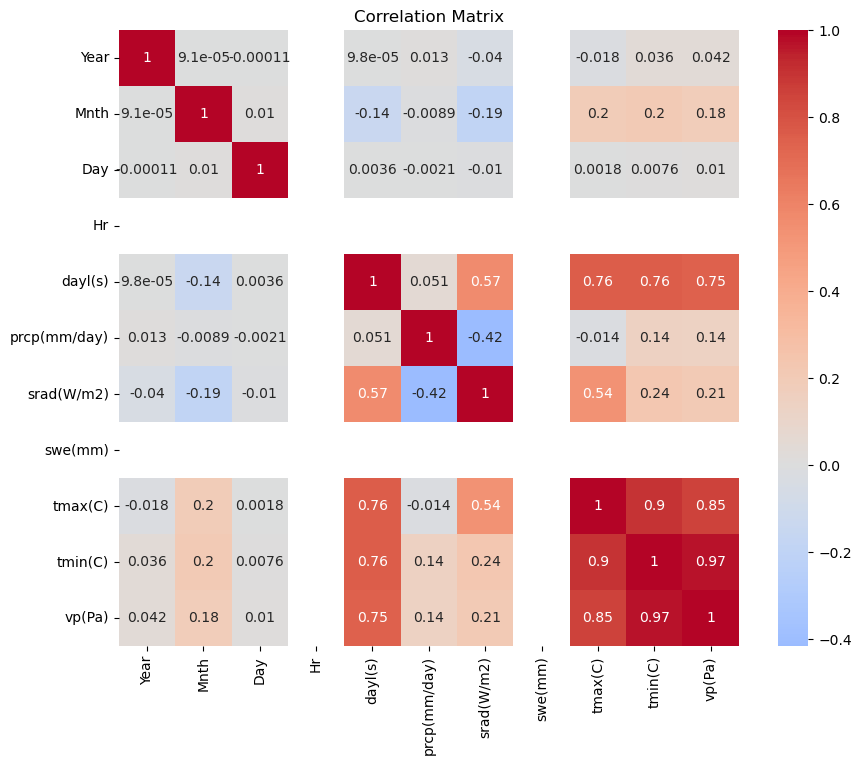

In [121]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [122]:
def load_forcing(basin: str) -> Tuple[pd.DataFrame, int]:
    """Load the meteorological forcing data of a specific basin.

    :param basin: 8-digit code of basin as string.
    
    :return: pd.DataFrame containing the meteorological forcing data and the
        area of the basin as integer.
    """
    # root directory of meteorological forcings
    forcing_path = CAMELS_ROOT / 'basin_mean_forcing' / 'daymet'
    
    # get path of forcing file
#     files = list(FILE_SYSTEM.glob(f"{str(forcing_path)}/**/{basin}_*.txt"))
    files = list(glob.glob(os.path.join(forcing_path, '**', f'{basin}_*.txt'), recursive=True))
    if len(files) == 0:
        raise RuntimeError(f'No forcing file file found for Basin {basin}')
    else:
        file_path = files[0]
    
    # read-in data and convert date to datetime index
#     with FILE_SYSTEM.open(file_path) as fp:
    with open(file_path, 'r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # load area from header
#     with FILE_SYSTEM.open(file_path) as fp:
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = int(content[2])

    return df, area


# def load_discharge(basin: str, area: int) ->  pd.Series:
#     """Load the discharge time series for a specific basin.

#     :param basin: 8-digit code of basin as string.
#     :param area: int, area of the catchment in square meters
    
#     :return: A pd.Series containng the catchment normalized discharge.
#     """
#     # root directory of the streamflow data
#     discharge_path = CAMELS_ROOT / 'usgs_streamflow'
    
#     # get path of streamflow file file
# #     files = list(FILE_SYSTEM.glob(f"{str(discharge_path)}/**/{basin}_*.txt"))
#     files = list(glob.glob(os.path.join(forcing_path, '**', f'{basin}_*.txt'), recursive=True))
#     if len(files) == 0:
#         raise RuntimeError(f'No discharge file found for Basin {basin}')
#     else:
#         file_path = files[0]

#     # read-in data and convert date to datetime index
#     col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
# #     with FILE_SYSTEM.open(file_path) as fp:
#     with open(file_path, 'r') as fp:
#         df = pd.read_csv(fp, sep='\s+', header=None, names=col_names)
#     dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
#              + df.Day.map(str))
#     df.index = pd.to_datetime(dates, format="%Y/%m/%d")

#     # normalize discharge from cubic feed per second to mm per day
#     df.QObs = 28316846.592 * df.QObs * 86400 / (area * 10 ** 6)

#     return df.QObs

def load_discharge(basin: str, area: int) -> pd.Series:
    """Load the discharge time series for a specific basin.

    :param basin: 8-digit code of basin as string.
    :param area: int, area of the catchment in square meters

    :return: A pd.Series containing the catchment normalized discharge.
    """
    # Root directory of the streamflow data
    discharge_path = CAMELS_ROOT / 'usgs_streamflow'
    
    # Use glob to get path of streamflow file
    files = list(glob.glob(str(discharge_path / f'**/{basin}_*.txt'), recursive=True))
    if len(files) == 0:
        raise RuntimeError(f'No discharge file found for Basin {basin}')
    else:
        file_path = files[0]

    # Read-in data and convert date to datetime index
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    with open(file_path, 'r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=None, names=col_names)

    # Convert date columns to datetime index
    dates = df.Year.astype(str) + "/" + df.Mnth.astype(str) + "/" + df.Day.astype(str)
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # Normalize discharge from cubic feet per second to mm per day
    # Constants are to convert CFS to cubic meters per second, and then to mm/day over area in square kilometers
    df['QObs'] = 28316846.592 * df['QObs'] * 86400 / (area * 10 ** 6)

    return df['QObs']

In [123]:
@njit
def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshape matrix data into sample shape for LSTM training.

    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction
    
    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.
    """
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

In [124]:
class CamelsTXT(Dataset):
    """Torch Dataset for basic use of data from the CAMELS data set.

    This data set provides meteorological observations and discharge of a given
    basin from the CAMELS data set.
    """

    def __init__(self, basin: str, seq_length: int=365,period: str=None,
                 dates: List=None, means: pd.Series=None, stds: pd.Series=None):
        """Initialize Dataset containing the data of a single basin.

        :param basin: 8-digit code of basin as string.
        :param seq_length: (optional) Length of the time window of
            meteorological input provided for one time step of prediction.
        :param period: (optional) One of ['train', 'eval']. None loads the 
            entire time series.
        :param dates: (optional) List of pd.DateTimes of the start and end date 
            of the discharge period that is used.
        :param means: (optional) Means of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_means() on the data set.
        :param stds: (optional) Stds of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_stds() on the data set.
        """
        self.basin = basin
        self.seq_length = seq_length
        self.period = period
        self.dates = dates
        self.means = means
        self.stds = stds

        # load data into memory
        self.x, self.y = self._load_data()

        # store number of samples as class attribute
        self.num_samples = self.x.shape[0]
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def _load_data(self):
        """Load input and output data from text files."""
        df, area = load_forcing(self.basin)
        df['QObs(mm/d)'] = load_discharge(self.basin, area)
        
        if self.dates is not None:
            # If meteorological observations exist before start date
            # use these as well. Similiar to hydrological warmup period.
            if self.dates[0] - pd.DateOffset(days=self.seq_length) > df.index[0]:
                start_date = self.dates[0] - pd.DateOffset(days=self.seq_length)
            else:
                start_date = self.dates[0]
            df = df[start_date:self.dates[1]]

        # if training period store means and stds
        if self.period == 'train':
            self.means = df.mean()
            self.stds = df.std()

        # extract input and output features from DataFrame
        x = np.array([df['prcp(mm/day)'].values,
                      df['srad(W/m2)'].values,
                      df['tmax(C)'].values,
                      df['tmin(C)'].values,
                      df['vp(Pa)'].values]).T
        y = np.array([df['QObs(mm/d)'].values]).T

        # normalize data, reshape for LSTM training and remove invalid samples
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data(x, y, self.seq_length)
        if self.period == "train":
            # Delete all samples, where discharge is NaN
            if np.sum(np.isnan(y)) > 0:
                print(f"Deleted some records because of NaNs {self.basin}")
                x = np.delete(x, np.argwhere(np.isnan(y)), axis=0)
                y = np.delete(y, np.argwhere(np.isnan(y)), axis=0)
            
            # Deletes all records, where no discharge was measured (-999)
            x = np.delete(x, np.argwhere(y < 0)[:, 0], axis=0)
            y = np.delete(y, np.argwhere(y < 0)[:, 0], axis=0)
            
            # normalize discharge
            y = self._local_normalization(y, variable='output')

        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))

        return x, y

    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Normalize input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - self.means["QObs(mm/d)"]) /
                       self.stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature
    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Rescale input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = feature * stds + means
        elif variable == 'output':
            feature = (feature * self.stds["QObs(mm/d)"] +
                       self.means["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

**Building an LSTM**

In [125]:
class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):
        """Initialize model
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=5, hidden_size=self.hidden_size,
                           num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
             containing the input data for the LSTM network.
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        #perform prediction only at the end of the input sequence
        pred=self.fc(self.dropout(h_n[-1,:,:]))
        return pred


**Train Utilities**

We define a function that will have to handle the training process, model evaluation, and performance assessment for an LSTM-based hydrological model.







In [126]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.tqdm_notebook(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

**Preparing Everything for training**

In [127]:
# basin = '01022500'    # can be changed to any 8-digit basin id contained in the CAMELS data set
basin = '02053800'#we try virginia again
#basin='12411000' 
#basin='12414500'
#basin='13083000'
#basin='13235000'
#basin='13240000'
#basin='13310700'
#basin='13313000'
#basin='13337000'
#basin='13338500'
#basin='13340000'
basin='13340600'
hidden_size = 10      # Number of LSTM cells
dropout_rate = 0.0    # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-3  # Learning rate used to update the weights
sequence_length = 365 # Length of the meteorological record provided to the network

# ##############
# # Data set up#
# ##############

# # Training data
start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[start_date, end_date])
print(ds_train)
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# Validation data. We use the feature means/stds of the training period for normalization
means = ds_train.get_means()
stds = ds_train.get_stds()
start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test data. We use the feature means/stds of the training period for normalization
start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)


#########################
# Model, Optimizer, Loss#
#########################
#the model will use one year of daily data for its predictions.
# Here we create our model, feel free
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [128]:
n_epochs = 20 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")

/var/folders/k7/8z45yf997x36mb4d9d0smphh0000gp/T/ipykernel_27972/3054175391.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm.tqdm_notebook(loader)


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.02


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.04


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.06


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.11


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.23


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.36


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.45


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.51


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.54


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.55


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.57


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.57


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.58


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.59


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.61


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.62


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.62


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.62


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.63


  0%|          | 0/20 [00:00<?, ?it/s]

Validation NSE: 0.65


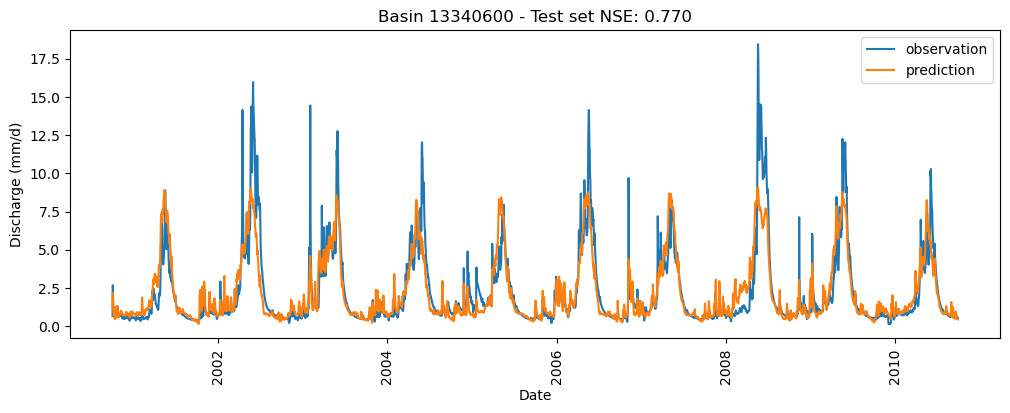

In [129]:
# Evaluate on test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Plot results
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="observation")
ax.plot(date_range, preds, label="prediction")
ax.legend()
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}")
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Date")
_ = ax.set_ylabel("Discharge (mm/d)")

**Therefore, we can try different basin IDs present in the CAMELS dataset and apply the LSTM as well as get information**